# CENSUS - Resort Town Tax Incentive Investigation
  
  Kalin Gibbons  
  Carlos Segura Cerna  
  Mark Baehr

<br>
<br>

## Required Python Modules

---

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import os
from census import Census
from us import states # Latest python=3.6.x
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.core.interactiveshell import InteractiveShell

import locale
locale.setlocale( locale.LC_ALL, '' );

In [2]:
# Has to be separate from the import cell to work
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<br>
<br>

## Data import
---

Current data sources include the 2010 census data, census-derived spending data from the George Wathington University Policy Institure, and the Local Option Tax revenue data provided by a subset of the 14 Idaho resort towns. The census data is accessed using a python module that wraps the government's census API inside simpler python method calls. Some useful links concerning available census variables, and the python modules used to access them, are provided in the following links:

* See [Initial Data Description](https://docs.google.com/document/d/1P0KDC9JeTSeFnT9454elcvP6jx3g0Svd7wPPidcbivE/edit?usp=sharing) for links to the census documentation.
* See [Python Census package](https://pypi.org/project/census/)
* See [Python us package](https://pypi.org/project/us/)
* See [census_definitions.pdf](https://drive.google.com/a/boisestate.edu/file/d/1CzdsmBPiqQmgiJW6DmjLTWG_P8dpcpfD/view?usp=sharing) for more detailed descriptions of the census variables.

These python packages interact with the census APIs using FIPs codes and have them built-in down to the county level, but we have to get the town-level FIPs codes from an excel file published by the government.

In [3]:
# Point python to the data folder, the census year of interest, and the list of 
# pilot towns.
datDir = os.path.join(os.getcwd(), 'data')
yearOfInterest = 2010
popLim = 10e3
townList = ('Hailey', 'Ketchum')
townList = [town + ' city' for town in townList]

# FIPS and PLACE codes
# -----------------------------------------------------------------------------
# State codes are easily called from the state module.
fipsIdaho = states.ID.fips

# Town codes must be imported.
geoCodes = pd.read_excel(
    os.path.join(datDir,'all_geocodes_v2016.xlsx'), header=4)
geoCodes.rename(
    columns={'Area Name (including legal/statistical area description)':'Area Name'}, 
    inplace=True)
geoCodes.set_index('Area Name', inplace=True)
townCodes = geoCodes.loc[townList, :]

# Make sure the towns are in Idaho.
idahoMask = townCodes.loc[:,'State Code (FIPS)'] == int(fipsIdaho)
townFips = townCodes.loc[idahoMask, 'Place Code (FIPS)']

# ---
townCodes
townFips

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS)
Area Name,,,,,,
Hailey city,162,16,0,0,34390,0
Ketchum city,162,16,0,0,43030,0


Area Name
Hailey city     34390
Ketchum city    43030
Name: Place Code (FIPS), dtype: int64

<br>
<br>

The cities shown within the filtered dataframe are all from Idaho. Now we can use their FIPS codes to pull data from the Census API. For a first pass, we'll use the population by housing unit, which should include populations excluding hotels, vacation rentals, etc. We'll start with the populations at the state- and county- levels, then handle the town revenues and populations.

### State and county populations

In [4]:
# 2010 census data
# ------------------------------------------------------------------------------
# * acs5: ACS 5 Year Estimates (2016, 2015, 2014, 2013, 2012, 2011, 2010)
# * acs1dp: ACS 1 Year Estimates, Data Profiles (2016, 2015, 2014, 2013, 2012)
# * sf1: Census Summary File 1 (2010, 2000, 1990)
# * sf3: Census Summary File 3 (2000, 1990)

census = Census('2ac5e0436e9326797fc8e7129ff3a00c85a7278a')
sf1 = census.sf1

# Add desirable variables to the census_vars.xlsx spreadsheet, as needed.
censusCipher = pd.read_excel(os.path.join(datDir, 'census_vars.xlsx'))
censusCipher = censusCipher.loc[:, ['api_var', 'dev_var']].set_index('api_var')
censusCipher = censusCipher.to_dict()['dev_var']

# Import the state-level data
idahoCensusData = pd.DataFrame(sf1.state(list(censusCipher.keys()),
                                         fipsIdaho, year=yearOfInterest))
idahoCensusData.rename(columns=censusCipher, inplace=True)

# Import the county-level data
countyCensusData = pd.DataFrame(sf1.state_county(list(censusCipher.keys()), 
                                                fipsIdaho, 
                                                Census.ALL, 
                                                year=yearOfInterest))
countyCensusData.rename(columns=censusCipher, inplace=True)

# ---
idahoCensusData.head()
countyCensusData.head()

,name,housingUnit,popByHousingUnit,state
0,Idaho,667796.000,1538631.000,16


,name,housingUnit,popByHousingUnit,state,county
0,"Bear Lake County, Idaho",3914.000,5955.000,16,007
1,"Benewah County, Idaho",4629.000,9215.000,16,009
2,"Ada County, Idaho",159471.000,382651.000,16,001
3,"Adams County, Idaho",2636.000,3955.000,16,003
4,"Bannock County, Idaho",33191.000,81047.000,16,005


<br>
<br>

The data imported from the Census API looks correct. Next we can import the local option tax revenues as well as the census-derived revenue for the state of Idaho.

### Local Option Tax Revenue

In [5]:
# 1 b) Local Option Tax revenue from resort towns, 2010-2019
# ------------------------------------------------------------------------------
lotTax = pd.read_excel(os.path.join(datDir, 'towns_lot_revenues.xlsx'))
lotTax.set_index('Town', inplace=True)


# 1 e) Census-derived revenue from the State of Idaho
# ------------------------------------------------------------------------------
idahoCensusFunds = pd.read_excel(
    os.path.join(datDir, 'gwu_by_state_fy2016_dev_friendly.xlsx'), header=2)
idahoCensusFunds = idahoCensusFunds.loc[:, ['Program','Idaho']]
idahoCensusFunds.rename(columns={'Idaho':'Amount'}, inplace=True)

# ---
lotTax
idahoCensusFunds.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Town,,,,,,,,,,
Hailey,311253.240,315603.980,335014.160,348850.260,422566.620,475799.930,543967.990,585178.010,593277.430,630565.680
Ketchum,1451069.880,1638904.070,1755694.500,1774377.860,2961925.740,3807206.470,4027047.670,4370168.720,4646897.970,4729557.790
Stanley,87716,128103,142159,147903,160590,202542,224716,247277,273394.000,259108
Lava Hot Springs,---,---,---,28635.170,30251.750,36481.400,44575.970,47788.440,50859.340,48688.380
Driggs,192330,180472,193370,217175,235563,247975,275360,305360,371954.000,514895
Victor,---,---,---,---,---,108730,127225,135066,417217.000,450000
Riggins,62299,58052,58248,59453,57445,67644,57731,94858,119236.000,117442
Ponderay,---,---,---,---,---,---,---,---,295000.000,---


,Program,Amount
0,Medical Assistance Program (Medicaid),1275769000.000
1,Federal Direct Student Loans,332836933.000
2,Supplemental Nutrition Assistance Program,255423930.000
3,Medicare Supplemental Medical Insurance (Part B),197553689.390
4,Highway Planning and Construction,299697316.000


<br>
<br>

No issues importing this data, but any analysis will require the census-derived funding at the town-level. To date, none of the contacted towns have reported receiving direct funding from any of the programs specified within the GWU dataset. Most programs distribute funds through various state or county committees / offices.

### Census-derived funding estimation

As a first pass, we can estimate town funding using a simple population proportion. We'll assume whatever proportion of Idaho's population lives within a given town, that is the proportion of funding they will receive. 

#### Town-level estimates

In [6]:
# Census-derived revenue from resort towns, 2010-2019
# ------------------------------------------------------------------------------

# Import the GWU state-level census spending data for Idaho (only 2016 data)
# Done, dataframe=idahoCensusFunds["Program","Amount"]

# Calculate town populations from the year 2010
townCensusData = pd.DataFrame()
for place, town in zip(townFips.tolist(), townFips.index):
    dummyDf = pd.DataFrame(sf1.state_place(list(censusCipher.keys()), 
                                           fipsIdaho, 
                                           place, 
                                           year=yearOfInterest))
    townCensusData = pd.concat([townCensusData, dummyDf])

del(dummyDf)
townCensusData.rename(columns=censusCipher, inplace=True)
townCensusData.reset_index(drop=True, inplace=True)

# Distribute state-level spending to towns by proportion of state population.
populationProportion = (townCensusData.loc[:, 'popByHousingUnit'].to_numpy() 
                        / idahoCensusData.loc[:, 'popByHousingUnit'].to_numpy())

townsCensusRevenue2016 = idahoCensusFunds.copy().rename(columns={'Amount':'Total'})
for idx in townCensusData.index:
    iName = townCensusData.loc[idx, 'name']
    townsCensusRevenue2016[iName] = (townsCensusRevenue2016.loc[:, 'Total'].to_numpy() 
                               * populationProportion[idx])
        
    
# ---
townCensusData
populationProportion
townsCensusRevenue2016.head()

,name,housingUnit,popByHousingUnit,state,place
0,"Hailey city, Idaho",3527.000,7894.000,16,34390
1,"Ketchum city, Idaho",3564.000,2689.000,16,43030


array([0.00513053, 0.00174766])

,Program,Total,"Hailey city, Idaho","Ketchum city, Idaho"
0,Medical Assistance Program (Medicaid),1275769000.000,6545377.343,2229607.255
1,Federal Direct Student Loans,332836933.000,1707631.491,581684.961
2,Supplemental Nutrition Assistance Program,255423930.000,1310461.380,446393.546
3,Medicare Supplemental Medical Insurance (Part B),197553689.390,1013556.092,345256.186
4,Highway Planning and Construction,299697316.000,1537607.531,523768.261


<br>
<br>

The GWU dataset was for the year 2016, only. So, we now have estimated town-level funding for one year, but we need to adjust this value for all the other years in the 2010 decade. We'll start by assuming that the funding amounts kept pace with an average inflationof 3% per year.

In [7]:
def simulate_census_revenue_for_locations(locationCensusRevenue, scalar, columns):
    '''Multiply a column of funding data by a scalar value.'''
    df = locationCensusRevenue.copy()
    for col in columns:
        df[col] = df[col].apply(lambda x: x*scalar)
    return df

# Let's calculate the Census-derived revenue from resort towns, 2010-2019
#townCensusRevenue2016
columns = list(townsCensusRevenue2016.filter(regex=('city|Total')).columns)

# Inflation increases amounts since 2016
townsCensusRevenue2017 = simulate_census_revenue_for_locations(townsCensusRevenue2016, 1.03, columns)
townsCensusRevenue2018 = simulate_census_revenue_for_locations(townsCensusRevenue2017, 1.03, columns)
townsCensusRevenue2019 = simulate_census_revenue_for_locations(townsCensusRevenue2018, 1.03, columns)

# Inflation decreases amounts before 2016
townsCensusRevenue2015 = simulate_census_revenue_for_locations(townsCensusRevenue2016, 0.97, columns)
townsCensusRevenue2014 = simulate_census_revenue_for_locations(townsCensusRevenue2015, 0.97, columns)
townsCensusRevenue2013 = simulate_census_revenue_for_locations(townsCensusRevenue2014, 0.97, columns)
townsCensusRevenue2012 = simulate_census_revenue_for_locations(townsCensusRevenue2013, 0.97, columns)
townsCensusRevenue2011 = simulate_census_revenue_for_locations(townsCensusRevenue2012, 0.97, columns)
townsCensusRevenue2010 = simulate_census_revenue_for_locations(townsCensusRevenue2011, 0.97, columns)

# ---
print('Year 2016')
townsCensusRevenue2016.head()
print('Year 2017')
townsCensusRevenue2017.head()

Year 2016


,Program,Total,"Hailey city, Idaho","Ketchum city, Idaho"
0,Medical Assistance Program (Medicaid),1275769000.000,6545377.343,2229607.255
1,Federal Direct Student Loans,332836933.000,1707631.491,581684.961
2,Supplemental Nutrition Assistance Program,255423930.000,1310461.380,446393.546
3,Medicare Supplemental Medical Insurance (Part B),197553689.390,1013556.092,345256.186
4,Highway Planning and Construction,299697316.000,1537607.531,523768.261


Year 2017


,Program,Total,"Hailey city, Idaho","Ketchum city, Idaho"
0,Medical Assistance Program (Medicaid),1314042070.000,6741738.663,2296495.473
1,Federal Direct Student Loans,342822040.990,1758860.436,599135.510
2,Supplemental Nutrition Assistance Program,263086647.900,1349775.221,459785.352
3,Medicare Supplemental Medical Insurance (Part B),203480300.071,1043962.775,355613.872
4,Highway Planning and Construction,308688235.480,1583735.757,539481.309


<br>
<br>

That's a 3% increase, so we can continue on to the county-level data. 

### County-level estimates

This data exists for five programs, but there are another 49 programs without data; we'll use the same estimation techniques for each program.

In [8]:
# TODO: Use the five programs with data to quantify error associated with 
# estimated revenue.

In [9]:
# Census-derived revenue from counties containing resort towns, 2010-2019
# ------------------------------------------------------------------------------

# Select the counties with resort towns which we have information about.
countyCensusData_withResortTowns = countyCensusData[countyCensusData['name'].isin([
    'Blaine County, Idaho', 
    'Custer County, Idaho', 
    'Bannock County, Idaho', 
    'Teton County, Idaho', 
    'Idaho County, Idaho', 
    'Bonner County, Idaho'])].reset_index()

# Distribute state-level spending to counties by proportion of state population.
populationProportion_counties = (countyCensusData_withResortTowns.loc[:, 'popByHousingUnit'].to_numpy() 
                        / idahoCensusData.loc[:, 'popByHousingUnit'].to_numpy())

# Calculate the census-derived revenue for the counties for the year 2016
countiesCensusRevenue2016 = idahoCensusFunds.copy().rename(columns={'Amount':'Total'})
for idx in countyCensusData_withResortTowns.index:
    iName = countyCensusData_withResortTowns.loc[idx, 'name']
    countiesCensusRevenue2016[iName] = (countiesCensusRevenue2016.loc[:, 'Total'].to_numpy() 
                               * populationProportion_counties[idx])
countiesCensusRevenue2016.head()

,Program,Total,"Bannock County, Idaho","Blaine County, Idaho","Bonner County, Idaho","Idaho County, Idaho","Custer County, Idaho","Teton County, Idaho"
0,Medical Assistance Program (Medicaid),1275769000.000,67200810.424,17510169.587,33600819.791,13053442.552,3604352.079,8426738.020
1,Federal Direct Student Loans,332836933.000,17532101.530,4568249.536,8766158.925,3405528.575,940343.817,2198461.977
2,Supplemental Nutrition Assistance Program,255423930.000,13454391.114,3505741.503,6727278.561,2613452.433,721633.597,1687131.873
3,Medicare Supplemental Medical Insurance (Part B),197553689.390,10406090.781,2711461.561,5203109.588,2021334.376,558136.348,1304886.061
4,Highway Planning and Construction,299697316.000,15786480.560,4113402.056,7893337.671,3066449.880,846716.485,1979567.435


In [10]:
# Calculate the census-derived revenue for counties from year 2010 to 2019
# set g: annual rate of change in funding
g = 0.03
columns = ['Total', 'Blaine County, Idaho', 'Custer County, Idaho', 'Bannock County, Idaho', 'Teton County, Idaho', 'Idaho County, Idaho', 'Bonner County, Idaho']

countiesCensusRevenue2017 = simulate_census_revenue_for_locations(countiesCensusRevenue2016, 1+g, columns)
countiesCensusRevenue2018 = simulate_census_revenue_for_locations(countiesCensusRevenue2017, 1+g, columns)
countiesCensusRevenue2019 = simulate_census_revenue_for_locations(countiesCensusRevenue2018, 1+g, columns)

countiesCensusRevenue2015 = simulate_census_revenue_for_locations(countiesCensusRevenue2016, 1-g, columns)
countiesCensusRevenue2014 = simulate_census_revenue_for_locations(countiesCensusRevenue2015, 1-g, columns)
countiesCensusRevenue2013 = simulate_census_revenue_for_locations(countiesCensusRevenue2014, 1-g, columns)
countiesCensusRevenue2012 = simulate_census_revenue_for_locations(countiesCensusRevenue2013, 1-g, columns)
countiesCensusRevenue2011 = simulate_census_revenue_for_locations(countiesCensusRevenue2012, 1-g, columns)
countiesCensusRevenue2010 = simulate_census_revenue_for_locations(countiesCensusRevenue2011, 1-g, columns)

# ---
print('Year 2016')
countiesCensusRevenue2016.head()
print('Year 2017')
countiesCensusRevenue2017.head()

Year 2016


,Program,Total,"Bannock County, Idaho","Blaine County, Idaho","Bonner County, Idaho","Idaho County, Idaho","Custer County, Idaho","Teton County, Idaho"
0,Medical Assistance Program (Medicaid),1275769000.000,67200810.424,17510169.587,33600819.791,13053442.552,3604352.079,8426738.020
1,Federal Direct Student Loans,332836933.000,17532101.530,4568249.536,8766158.925,3405528.575,940343.817,2198461.977
2,Supplemental Nutrition Assistance Program,255423930.000,13454391.114,3505741.503,6727278.561,2613452.433,721633.597,1687131.873
3,Medicare Supplemental Medical Insurance (Part B),197553689.390,10406090.781,2711461.561,5203109.588,2021334.376,558136.348,1304886.061
4,Highway Planning and Construction,299697316.000,15786480.560,4113402.056,7893337.671,3066449.880,846716.485,1979567.435


Year 2017


,Program,Total,"Bannock County, Idaho","Blaine County, Idaho","Bonner County, Idaho","Idaho County, Idaho","Custer County, Idaho","Teton County, Idaho"
0,Medical Assistance Program (Medicaid),1314042070.000,69216834.736,18035474.675,34608844.385,13445045.828,3712482.641,8679540.161
1,Federal Direct Student Loans,342822040.990,18058064.576,4705297.022,9029143.693,3507694.432,968554.132,2264415.836
2,Supplemental Nutrition Assistance Program,263086647.900,13858022.848,3610913.748,6929096.918,2691856.006,743282.605,1737745.829
3,Medicare Supplemental Medical Insurance (Part B),203480300.071,10718273.504,2792805.407,5359202.876,2081974.407,574880.439,1344032.643
4,Highway Planning and Construction,308688235.480,16260074.976,4236804.118,8130137.801,3158443.377,872117.980,2038954.458


<br>
<br>

That's a 3% increase year-over-year. We can now move on to analyzing our simulated data.

## Initial investigation

---

Our initial analysis will focus on estimating the marginal costs and benefits associated with the census / LOT option for a single town: Hailey, Idaho. This town has the most complete data, and is also in danger of exceeding the 10,000 person LOT option population limit. We'll pretend the above data was not simulated, and 

1. Estimate spending for the 2021-2030 decade

    * federal spending for the 2021-2030 decade
    
    * marginal financial impact of an aditional person being counted on the City of Hailey

    * marginal financial impact of an additional person being counted on Blaine County

    * marginal financial impact of an additional person being counted on the State of Idaho

    * resort tax revenue for 2021-2030

1. Construct an integrated model of costs and benefits for the involved entities

    * Perform a break-even analysis at which additional census-derived funding offsets lost LOT option revenue
    
    * Repeat this analysis at the county-level, collecting the towns by county

    * Repeat for the state-level, with all towns collected

### Estimated spending for the 2021-2030 decade

Start with Hailey City / Blaine County

In [11]:
BlaineGrowth = pow(countiesCensusRevenue2019['Blaine County, Idaho'].sum()
                   /countiesCensusRevenue2010['Blaine County, Idaho'].sum()
                   ,1/9.0)
BlaineFutureFunding = 0
for i in range(2,11): # loop over years 2021-2030
    BlaineFutureFunding += (countiesCensusRevenue2019['Blaine County, Idaho'].sum()*(pow(BlaineGrowth,i)))

print(('With a growth rate of {:.3f}, Blaine County should receive ${:0,.0f}' 
      + ' of additional funding within the next decade.')
      .format(BlaineGrowth, BlaineFutureFunding))

With a growth rate of 1.031, Blaine County should receive $591,647,683 of additional funding within the next decade.


<br>
<br>

The growth rate matches the simulated inflation rate, as expected. Next, we can estimate the resort tax revenue for the coming decade.

In [12]:
# Estimating LOT revenue for years 2021-2030
# Identical effect for the state, assuming all funds received by the state are disbursed
HaileyLotGrowth = pow((lotTax.loc['Hailey'][2019]/lotTax.loc['Hailey'][2010]),1/9.0)
HaileyFutureFunding = 0
for i in range(2,11): # loop over years 2021-2030
    HaileyFutureFunding += (lotTax.loc['Hailey'][2019]*pow(HaileyLotGrowth,i))

print(('With a growth rate of {:.3f}, Hailey City should receive ${:0,.0f}' 
      + ' of additional funding within the next decade.')
      .format(HaileyLotGrowth, HaileyFutureFunding))

With a growth rate of 1.082, Hailey City should receive $9,273,743 of additional funding within the next decade.


<br>
<br>

The LOT revenue data for Hailey was complete, so the growth rate really *did* exceed inflation.

In [13]:
# FIXME: Remove hard-coded magic numbers -> Generalize for loop of every town/county
HaileyIdx = 0;
BlaineIdx = 6;

# calculating per capita funding in Blaine County
BlainePerCapFund = BlaineFutureFunding/countyCensusData.iloc[BlaineIdx]['popByHousingUnit']

# calculating the approximate percentage of Blaine County's population residing in Hailey
HaileyBlainePopRatio = (townCensusData.iloc[HaileyIdx]['popByHousingUnit']
                        /countyCensusData.iloc[BlaineIdx]['popByHousingUnit'])

# Calculating the number of additional person counted beyond 10000 such that the extra census funding
# outweighs the lost LOT revenue as a result of losing resort town status
# NOTE: Assumes 100% of census driven revenue is directly proportional to population
Threshold = (HaileyFutureFunding/BlainePerCapFund)*HaileyBlainePopRatio

print(('Hailey\'s funding after losing the LOT option will break even when'
       + ' population exceeds {:0.0f} people.').format(popLim + Threshold))

Hailey's funding after losing the LOT option will break even when population exceeds 10124 people.


<br>
<br>

So, if census-derived funding was perfectly proportional to population, and that funding kept exact pace with our estimated inflation, Hailey City would not have financial incentives to ensure accurate census counts until their population exceeded the limit by more that 100 people.

Let's perform the same calculation for a range of funding values, and plot the population results. We'll assume that funding proportional to population is a conservative estimate, and reduce that funding 


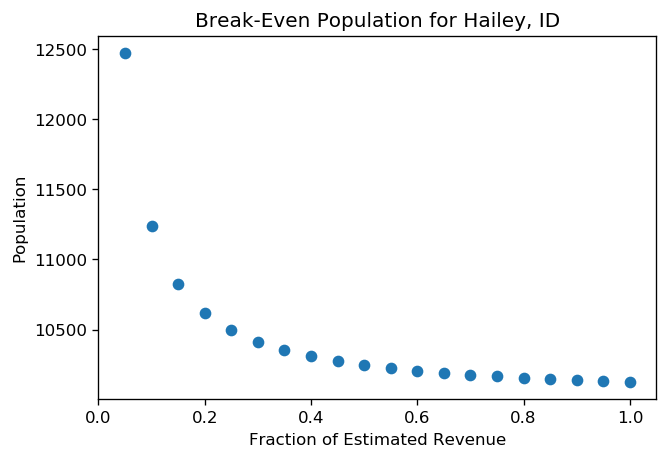

In [14]:
## Finding thresholds with more realisic assumptions regarding funding determination
nPoints = 20
thresholds = np.zeros(nPoints)
revenueFraction = np.zeros(nPoints)
for i in range(0, nPoints):
    revenueFraction[i] = (i + 1) / float(nPoints)
    thresholds[i] = math.ceil(popLim
                              + (HaileyFutureFunding / BlainePerCapFund)
                              * HaileyBlainePopRatio
                              / revenueFraction[i])
    
# Graphing population thresholds for given fractions of census determined revenues
fig = plt.figure(dpi=120)
ax = plt.axes(
    xlabel = 'Fraction of Estimated Revenue',
    ylabel='Population',
    title='Break-Even Population for Hailey, ID',
    xlim=(0, revenueFraction.max() + 0.05))

popLin = plt.scatter(y=thresholds,x=revenueFraction);
plt.show()

<br>
<br>

It looks like the break-even population decays exponentially as census-derived funding increases. For any town performing this analysis, it will be critical to quantify their census-derived funding. We'll end this milestone with a list of those population values.

In [15]:
#producing the above results in a table
HaileyDF = pd.DataFrame(thresholds)
HaileyDF['Revenue Fraction'] = revenueFraction
HaileyDF.rename( columns = {
    0 : 'Population Threshold'
}, inplace = True)
HaileyDF

,Population Threshold,Revenue Fraction
0,12475.000,0.050
1,11238.000,0.100
2,10825.000,0.150
3,10619.000,0.200
4,10495.000,0.250
5,10413.000,0.300
6,10354.000,0.350
7,10310.000,0.400
8,10275.000,0.450
9,10248.000,0.500
